In [20]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from shutil import copyfile
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, LSTM, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [21]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    spectrograms_dir = "/content/drive/MyDrive/audio_representations/"
else :
    base_dir = "audio_representations/"

In [22]:
def create_balanced_combined_dataset(datasets_dirs, combined_dir, max_samples_per_emotion=None):
    """
    Crée un dataset combiné équilibré en prenant un nombre égal d'échantillons pour chaque émotion.

    :param datasets_dirs: Dictionnaire avec les noms des datasets et leurs chemins
    :param combined_dir: Chemin du dossier de sortie
    :param max_samples_per_emotion: Nombre maximum d'échantillons par émotion (optionnel)
    """
    emotion_files = defaultdict(list)  # Dictionnaire pour stocker les fichiers par émotion

    # Étape 1 : Collecter les fichiers par émotion
    for dataset_name, dataset_dir in datasets_dirs.items():
        if not os.path.exists(dataset_dir):
            print(f"Le dossier {dataset_name} n'existe pas : {dataset_dir}")
            continue

        spectrogram_files = [f for f in os.listdir(dataset_dir) if os.path.isfile(os.path.join(dataset_dir, f))]
        for file in spectrogram_files:
            try:
                # Extraire le code émotionnel (3e valeur du nom, selon votre format)
                parts = file.split('-')
                emotion_code = int(parts[2])
                emotion_files[emotion_code].append((dataset_name, file))
            except (IndexError, ValueError):
                print(f"Fichier ignoré (format incorrect) : {file}")

    # Étape 2 : Déterminer le nombre d'échantillons par émotion
    min_samples = min(len(files) for files in emotion_files.values())  # Nombre minimal d'échantillons disponibles
    if max_samples_per_emotion:
        min_samples = min(min_samples, max_samples_per_emotion)  # Limiter à max_samples_per_emotion si spécifié

    print(f"Échantillonnage équilibré : {min_samples} fichiers par émotion")

    # Étape 3 : Créer l'échantillon équilibré
    os.makedirs(combined_dir, exist_ok=True)
    for emotion_code, files in emotion_files.items():
        sampled_files = random.sample(files, min_samples)
        for dataset_name, file in sampled_files:
            src = os.path.join(datasets_dirs[dataset_name], file)
            dst = os.path.join(combined_dir, f"{dataset_name}_{file}")
            copyfile(src, dst)

    print(f"Dataset combiné équilibré créé dans : {combined_dir}")

# Exemple d'appel
datasets_dirs = {
    "RAVDESS": os.path.join(base_dir, "audio_representations_ravdess/spectrograms"),
    "TESS": os.path.join(base_dir, "audio_representations_Tess/spectrograms"),
    "SAVEE": os.path.join(base_dir, "audio_representations_savee/spectrograms")
}

combined_dir = os.path.join(base_dir, "balanced_combined_dataset")
create_balanced_combined_dataset(datasets_dirs, combined_dir, max_samples_per_emotion=300)


Échantillonnage équilibré : 192 fichiers par émotion
Dataset combiné équilibré créé dans : audio_representations/balanced_combined_dataset


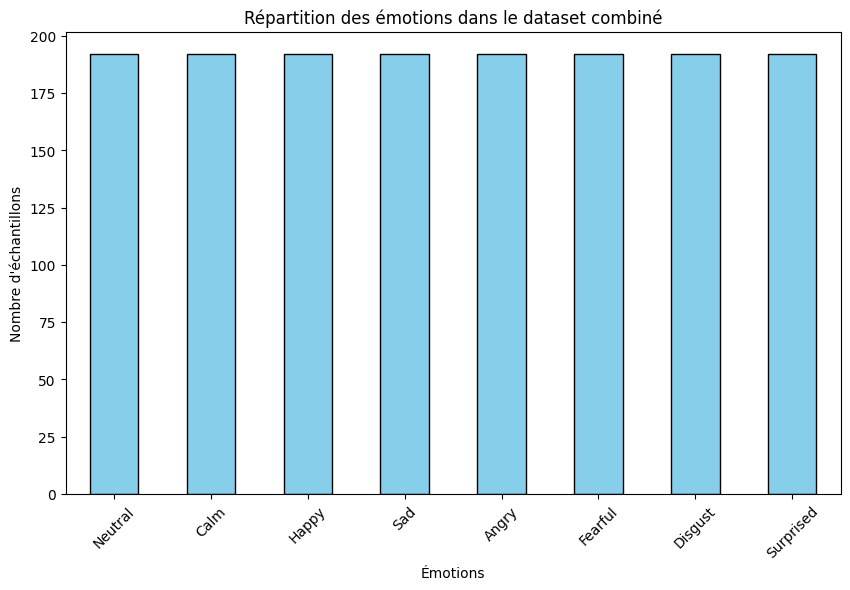

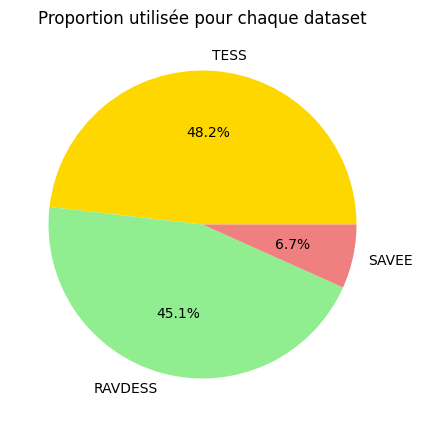

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Fonction pour analyser et générer des graphiques

def analyze_combined_dataset(combined_dir):
    """Analyse le dataset combiné et génère des graphiques."""
    # Extraire les informations des noms de fichiers
    files = [f for f in os.listdir(combined_dir) if os.path.isfile(os.path.join(combined_dir, f))]
    data = []

    for file in files:
        # Extraction des métadonnées à partir du nom du fichier
        parts = file.split('_')
        if len(parts) < 2:
            continue
        dataset = parts[0]  # Nom du dataset d'origine

        # Identification de l'émotion à partir du nom du fichier (3e valeur numérique)
        try:
            emotion_code = int(parts[1].split('-')[2])
        except (IndexError, ValueError):
            continue

        # Correspondance des codes émotionnels aux émotions
        emotion_map = {
            1: 'Neutral',
            2: 'Calm',
            3: 'Happy',
            4: 'Sad',
            5: 'Angry',
            6: 'Fearful',
            7: 'Disgust',
            8: 'Surprised'
        }
        emotion = emotion_map.get(emotion_code, 'Unknown')

        data.append({'Dataset': dataset, 'Emotion': emotion})

    # Conversion en DataFrame pour l'analyse
    df = pd.DataFrame(data)

    # Graphique 1 : Répartition des émotions
    plt.figure(figsize=(10, 6))
    df['Emotion'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Répartition des émotions dans le dataset combiné')
    plt.xlabel('Émotions')
    plt.ylabel('Nombre d\'échantillons')
    plt.xticks(rotation=45)
    plt.show()

    # Graphique 2 : Proportion utilisée pour chaque dataset
    plt.figure(figsize=(8, 5))
    df['Dataset'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['gold', 'lightgreen', 'lightcoral'])
    plt.title('Proportion utilisée pour chaque dataset')
    plt.ylabel('')
    plt.show()

    return df

# Exemple d'appel de la fonction
combined_dir = "audio_representations/balanced_combined_dataset"
df_combined = analyze_combined_dataset(combined_dir)


In [3]:
images = []
labels = []

for file_name in os.listdir(spectrograms_dir):
    if file_name.endswith(".png"):
        file_path = os.path.join(spectrograms_dir, file_name)

        # Convert to numpy
        img = Image.open(file_path).convert("RGB")
        img = img.resize((256, 256))
        img_array = np.array(img)

        images.append(img_array)

        label = int(file_name.split("-")[2]) - 1
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

# Normalize
images = images / 255.0

# One hot
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Ensemble d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Ensemble de validation : {X_val.shape}, {y_val.shape}")
print(f"Ensemble de test : {X_test.shape}, {y_test.shape}")

Ensemble d'entraînement : (1008, 256, 256, 3), (1008, 8)
Ensemble de validation : (216, 256, 256, 3), (216, 8)
Ensemble de test : (216, 256, 256, 3), (216, 8)


In [4]:
def create_cnn_blstm_attention_model(input_shape, num_classes):
    # Définir l'entrée
    input_layer = Input(shape=input_shape)

    # Partie CNN
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Applatir la sortie du CNN
    x = Flatten()(x)

    # Reshape pour LSTM (pour créer une séquence de features)
    x = Reshape((1, -1))(x)  # reshape pour (batch_size, time_steps, features)

    # Partie BLSTM
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    # Ajouter la couche d'attention (Attention layer attend une liste d'entrées)
    attention_output = Attention()([x, x])  # Ici, on applique l'attention sur la sortie de LSTM

    # Ajouter un fully connected layer
    x = Flatten()(attention_output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout pour éviter le surapprentissage

    # Couche de sortie
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Créer le modèle
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compiler le modèle
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Définir l'entrée et les classes
input_shape = (256, 256, 3)  # Taille des images (256x256, 3 canaux RGB)
num_classes = 8  # Exemple de 7 classes d'émotions

# Créer le modèle
model = create_cnn_blstm_attention_model(input_shape, num_classes)

# Résumé du modèle
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 254, 254, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 127, 127, 32)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 125, 125, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 62, 62, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 60, 60, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 30, 30, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 115200)         │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 115200)      │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 1, 128)         │     59,015,680 │ reshape[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 1, 128)         │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 128)            │              0 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         16,512 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 8)              │          1,032 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 59,126,472 (225.55 MB)

 Trainable params: 59,126,472 (225.55 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Loss on the test set : {test_loss}")
print(f"Accuracy on the test set : {test_accuracy}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 193ms/step - accuracy: 0.1597 - loss: 2.0648 - val_accuracy: 0.3056 - val_loss: 1.7998
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.3987 - loss: 1.6560 - val_accuracy: 0.4907 - val_loss: 1.4292
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.4966 - loss: 1.3765 - val_accuracy: 0.5093 - val_loss: 1.4083
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.5890 - loss: 1.0874 - val_accuracy: 0.5556 - val_loss: 1.2182
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.7034 - loss: 0.8477 - val_accuracy: 0.5602 - val_loss: 1.2577
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.8187 - loss: 0.6268 - val_accuracy: 0.5324 - val_loss: 1.2455
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.8868 - loss: 0.4382 - val_accuracy: 0.6389 - val_loss: 1.2201
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9229 - loss: 0.2872 - val_accuracy: 0.6065 - val

In [6]:
save_path = '/content/drive/MyDrive/models/cnn_blstm_attention_ravdess_spectrograms'

model.save(save_path + "/weights.h5")

In [7]:
plt.figure(figsize=(6, 5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(save_path, "loss_curve.png"))
plt.close()

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Evolution")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(save_path, "accuracy_curve.png"))
plt.close()


In [8]:
emotion_labels = [
    "Neutral", "Calm", "Happy", "Sad", "Angry",
    "Fearful", "Disgust", "Surprised"
]

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=emotion_labels
)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix CNN-BLSTM with attention Spectrograms")
conf_matrix_path = os.path.join(save_path, "confusion_matrix.png")
plt.savefig(conf_matrix_path)
plt.close()


3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
